# Imports

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import tifffile as tiff
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import skimage
from skimage.io import imread, imsave
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import rasterio


import tensorflow as tf
import keras
import keras.layers

sys.path.insert(0, '../')
from src.utils import *
from src.config import *
from src.prepare_data import prepare_SPARCS, prepare_biome8, prepare_S2

seed_value = 42

# Set the random seed for Python's built-in random module
random.seed(seed_value)

# Set the random seed for numpy
np.random.seed(seed_value)

# Set the random seed for TensorFlow
tf.random.set_seed(seed_value)

2023-07-12 19:04:22.090893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 19:04:23.135545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Setup

In [3]:
# Create the patches and divide them into train, validation and test sets
prepare_biome8()

In [ ]:
# get_biome8()[0].shape, get_biome8()[1].shape, get_biome8('valid')[0].shape, get_biome8('valid')[1].shape, get_biome8('test')[0].shape, get_biome8('test')[1].shape

Loading data: 100%|██████████| 9445/9445 [00:10<00:00, 869.95it/s]


((71423, 240, 240, 4),
 (71423, 240, 240, 1),
 (9387, 240, 240, 4),
 (9387, 240, 240, 1),
 (9445, 240, 240, 4),
 (9445, 240, 240, 1))

In [4]:
# Chack the correct images size
get_biome8()[0].shape, get_biome8()[1].shape, get_biome8('valid')[0].shape, get_biome8('valid')[1].shape, get_biome8('test')[0].shape, get_biome8('test')[1].shape

Loading data: 100%|██████████| 14923/14923 [00:18<00:00, 820.48it/s]


((67736, 240, 240, 4),
 (67736, 240, 240, 1),
 (7518, 240, 240, 4),
 (7518, 240, 240, 1),
 (14923, 240, 240, 4),
 (14923, 240, 240, 1))

In [7]:
# biome_train = get_biome8('train')
# biome_valid = get_biome8('valid')
images, masks = get_biome8('test', only_rgb=True, full_image=True)

Loading data: 100%|██████████| 16/16 [02:15<00:00,  8.48s/it]


In [6]:
images, masks = get_biome8('test')
np.unique(images), np.unique(masks)

Loading data: 100%|██████████| 14923/14923 [00:20<00:00, 714.58it/s]


(array([0.06666667, 0.07058824, 0.0745098 , 0.07843137, 0.08235294,
        0.08627451, 0.09019608, 0.09411765, 0.09803922, 0.10196078,
        0.10588235, 0.10980392, 0.11372549, 0.11764706, 0.12156863,
        0.1254902 , 0.12941176, 0.13333333, 0.1372549 , 0.14117647,
        0.14509804, 0.14901961, 0.15294118, 0.15686275, 0.16078431,
        0.16470588, 0.16862745, 0.17254902, 0.17647059, 0.18039216,
        0.18431373, 0.18823529, 0.19215686, 0.19607843, 0.2       ,
        0.20392157, 0.20784314, 0.21176471, 0.21568627, 0.21960784,
        0.22352941, 0.22745098, 0.23137255, 0.23529412, 0.23921569,
        0.24313725, 0.24705882, 0.25098039, 0.25490196, 0.25882353,
        0.2627451 , 0.26666667, 0.27058824, 0.2745098 , 0.27843137,
        0.28235294, 0.28627451, 0.29019608, 0.29411765, 0.29803922,
        0.30196078, 0.30588235, 0.30980392, 0.31372549, 0.31764706,
        0.32156863, 0.3254902 , 0.32941176, 0.33333333, 0.3372549 ,
        0.34117647, 0.34509804, 0.34901961, 0.35

# Visualizations

In [5]:
image_paths = sorted(list(biome_raw_dir.glob('**/*.TIF')))  # List of image file paths
mask_paths = sorted(list(biome_raw_dir.glob('**/*.img')))
# image_paths
# sorted(os.listdir(biome_raw_dir))
# LC80010112014080LGN00
# LC80010732013109LGN00
# /home/floddo/cloud_coverage_TOELT_SUPSI/Data/L8_Biome8/raw/Shrubland/BC/LC80010732013109LGN00

In [6]:
# select a random image and load the RGB bands and the mask
ID = 'LC80010732013109LGN00'
B2 = tiff.imread(Path(biome_raw_dir, 'Shrubland/BC/', '{}/{}_B2.TIF'.format(ID, ID)))
B3 = tiff.imread(Path(biome_raw_dir, 'Shrubland/BC/', '{}/{}_B3.TIF'.format(ID, ID)))
B4 = tiff.imread(Path(biome_raw_dir, 'Shrubland/BC/', '{}/{}_B4.TIF'.format(ID, ID)))
im = np.dstack((B4, B3, B2))
im = np.clip(im/65536,0,1)

Min value: 0.0
Max value: 0.9716949462890625
Mean value: 0.13706119929983282
Median value: 0.1505126953125
Standard deviation: 0.11720675148312731


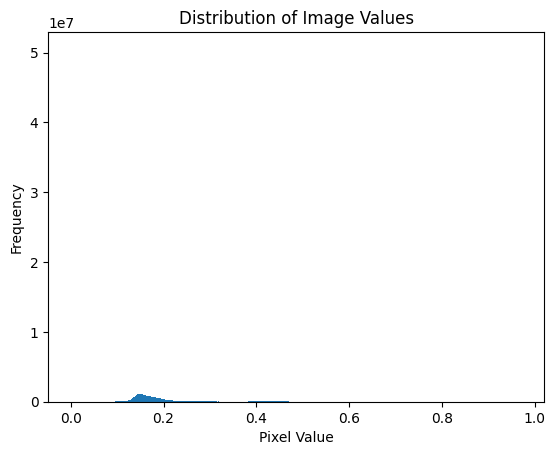

In [7]:
# Flatten the array to a 1D array
flat_array = im.flatten()

# Calculate the statistical measures
min_value = np.min(flat_array)
max_value = np.max(flat_array)
mean_value = np.mean(flat_array)
median_value = np.median(flat_array)
std_deviation = np.std(flat_array)

# Print the statistical measures
print("Min value:", min_value)
print("Max value:", max_value)
print("Mean value:", mean_value)
print("Median value:", median_value)
print("Standard deviation:", std_deviation)

# Plot a histogram of the values
plt.hist(flat_array, bins='auto')
plt.title("Distribution of Image Values")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

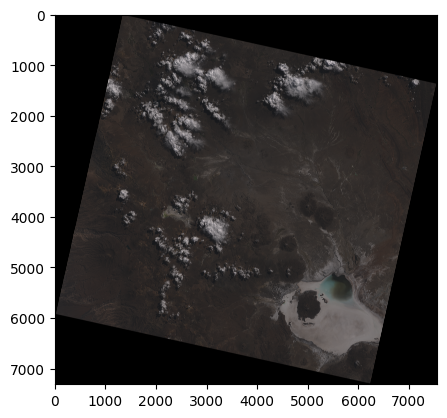

In [8]:
# RGB image
plt.imshow(im)

Image mask shape: (7311, 7561)
Image mask data type: uint8
Image mask unique values: {0, 64, 128, 192, 255}


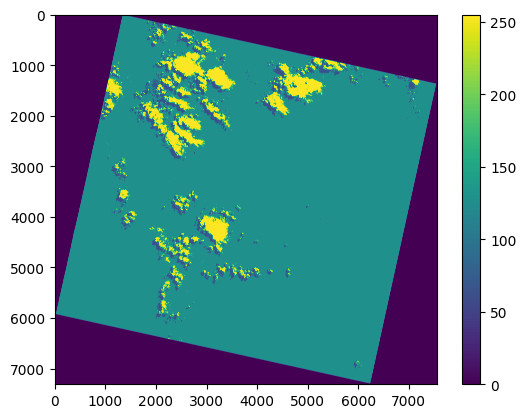

In [9]:
# Specify the file path
file_path = Path(biome_raw_dir, 'Shrubland/BC/', "LC80010732013109LGN00/LC80010732013109LGN00_fixedmask.img")

# Open the image mask file
with rasterio.open(file_path) as dataset:
    # Access the image mask data
    image_mask = dataset.read(1)  # Assuming it is a single-band image, change the index if necessary

    # Perform operations on the image mask
    # For example, you can print some information about the image
    print("Image mask shape:", image_mask.shape)
    print("Image mask data type:", image_mask.dtype)
    print("Image mask unique values:", set(image_mask.flatten()))



# At this link we can find the meaning of the values in the mask: https://landsat.usgs.gov/landsat-8-cloud-cover-assessment-validation-data
# Value	   Interpretation
# 0	       Fill
# 64	   Cloud Shadow
# 128	   Clear
# 192	   Thin Cloud
# 255	   Cloud

# Plot the image mask
plt.imshow(image_mask)
plt.colorbar()


In [22]:
np.random.seed(seed_value)
idxs = np.random.randint(len(images), size=5)

ims = images[idxs]
ms = masks[idxs]

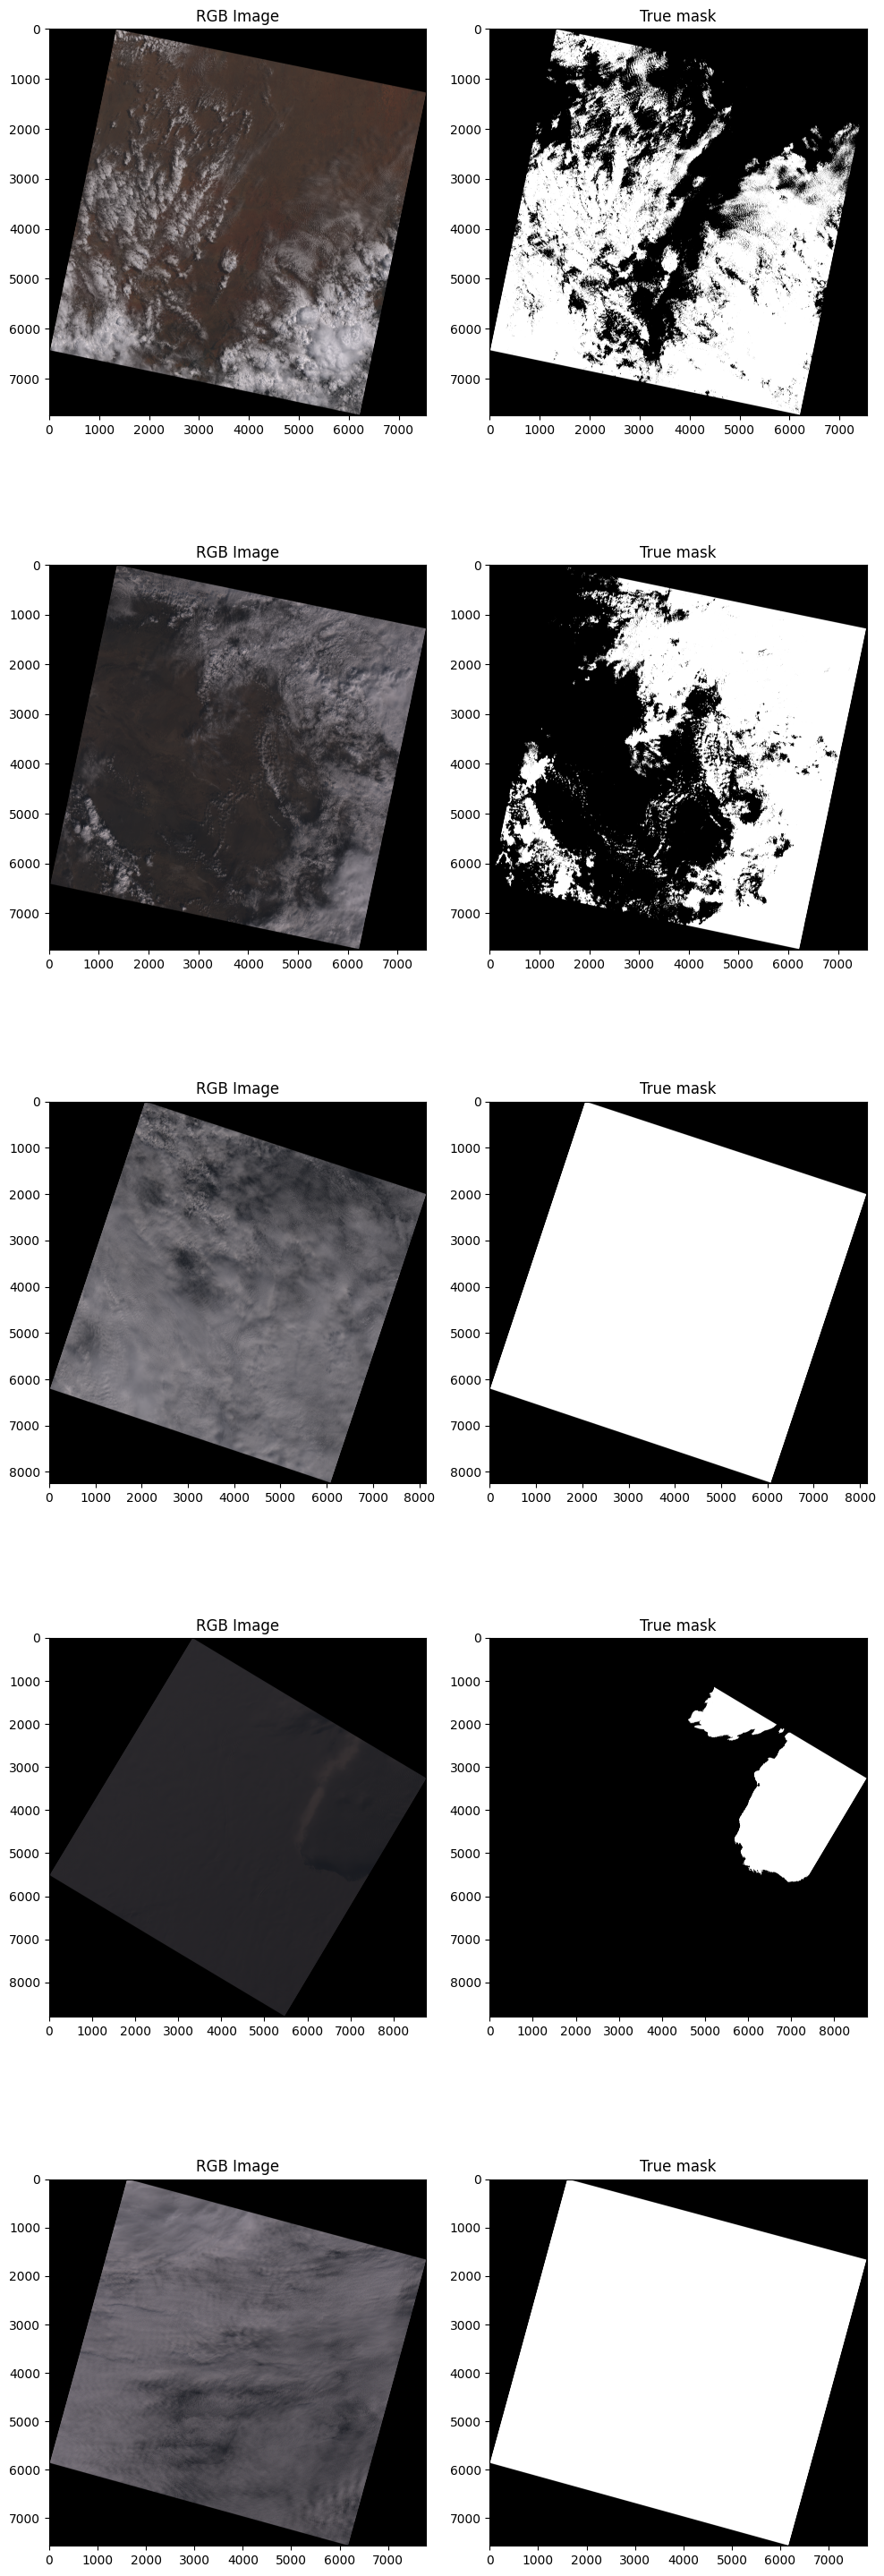

In [23]:
fig, ax = plt.subplots(len(idxs), 2, figsize=(10, 30))

for i in range(len(idxs)):
    ax[i, 0].imshow(ims[i])
    ax[i, 0].set_title('RGB Image')
    ax[i, 1].imshow(ms[i] == 1 , cmap='gray')
    ax[i, 1].set_title('Mask')

# Adjust the spacing between subplots
plt.tight_layout()

# # Display the figure
plt.show()